# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

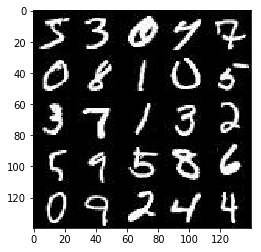

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

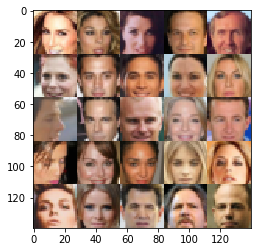

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    ##############################################################
    # Notifications:
    #  all hyper parameters and activation function are set
    #  according to the DCGAN paper
    ##############################################################
    
    # I always use discriminator as a trainer for the generator 
    is_training = True
        
    # (from the paper)
    # >> In the LeakyReLU, the slope of the leak was set to 0.2 in all models
    alpha = 0.2
        
    # (from the paper)
    # >> All weights were initialized from a zero-centered Normal distribution
    # >> with standard deviation 0.02
    d_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # CONV layer w/o batch normalization and LeakyReLU
        # 28x28 to 14x14x64
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=d_initializer)
        conv1 = tf.nn.leaky_relu(conv1, alpha=alpha)
        
        # CONV layer w/ batch normalization and LeakyReLU
        # 14x14x64 to 7x7x128
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=d_initializer)
        conv2 = tf.layers.batch_normalization(conv2, training=is_training)
        conv2 = tf.nn.leaky_relu(conv2, alpha=alpha)
        
        # CONV layer w/ batch normalization and LeakyReLU
        # 7x7x128 to 3x3x256
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', kernel_initializer=d_initializer)
        conv3 = tf.layers.batch_normalization(conv3, training=is_training)
        conv3 = tf.nn.leaky_relu(conv3, alpha=alpha)
        
        # Output layer (Binary classifier)
        flat = tf.layers.flatten(conv3)
        logits = tf.layers.dense(flat, 1, kernel_initializer=d_initializer)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    ##############################################################
    # Notifications:
    #  almost all hyper parameters are set
    #  according to the DCGAN paper (same as the discriminator)
    #  
    #  In the DCGAN paper, author mentions about the generator like following:
    #  >> Use ReLU activation in generator for all layers 
    #  >> except for the output, which uses Tanh.
    #   
    #  However, I need to actively treat the negative values in this project,
    #  I decided to use the leakyRelu function as a activation function like the "dcgan-svhn" lesson.
    #  
    ##############################################################
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        g_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        
        # Fully-connected layer
        # z shape to (512x4x4)
        x1 = tf.layers.dense(z, 512 * 4 * 4, activation=None, kernel_initializer=g_initializer)
        
        # Reshape into the convolutional stack
        # (512x4x4) to 4x4x512
        conv1 = tf.reshape(x1, shape=[-1, 4, 4, 512])
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.nn.leaky_relu(conv1, alpha=alpha)
        
        # Transposed CONV layer w/ batch normalization and ReLU
        # 4x4x512 to 7x7x256
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 4, strides=1, padding='valid', 
                                            activation=None, kernel_initializer=g_initializer)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.nn.leaky_relu(conv2, alpha=alpha)
        
        # Transposed CONV layer w/ batch normalization and ReLU
        # 7x7x256 to 14x14x128
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same', 
                                            activation=None, kernel_initializer=g_initializer)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.nn.leaky_relu(conv3, alpha=alpha)
        
        # Output layer
        # 14x14x128 to 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same',
                                            activation=None, kernel_initializer=g_initializer)
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # One-sided label
    smooth = 0.9
    
    # Generate models
    g_output = generator(input_z, out_channel_dim, is_train=True)
    # Real image discrimination
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    # Fake image discrimination
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)

    # Loss for the discriminater 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Loss for the generator 
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable variables and separate into two parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Iteration counter
    n_iter = 0
    # Image numbers to monitor
    show_n_images = 25
    # Printing parameters
    print_every = 20
    show_every = 100
    
    # Build the Graph
    input_real, input_z, lr = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                # rescale images into range[-1,1] to fit the tanh output of the generator
                batch_images *= 2
                
                # increment a iteration counter
                n_iter += 1
                
                # Create z data for feeding to the graph
                batch_z = np.random.uniform(low=-1, high=1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, 
                             feed_dict={
                                 input_real: batch_images,
                                 input_z: batch_z, 
                                 lr: learning_rate})                
                _ = sess.run(g_opt, 
                             feed_dict={
                                 input_real: batch_images,
                                 input_z: batch_z, 
                                 lr: learning_rate})                
                
                # Print losses in each 20 iteration
                if n_iter % print_every == 0:
                    train_loss_d = sess.run(d_loss, 
                                            feed_dict={
                                                input_real: batch_images, 
                                                input_z: batch_z,
                                                lr: learning_rate})
                    train_loss_g = sess.run(g_loss,
                                            feed_dict={
                                                input_real: batch_images, 
                                                input_z: batch_z,
                                                lr: learning_rate})
                    print('epoch: {}/{}'.format(epoch_i+1, epoch_count),
                          'iteration: {} ... '.format(n_iter),
                          'd_loss: {:.4f}'.format(train_loss_d), 
                          'g_loss: {:.4f}'.format(train_loss_g))
                    
                # Print the generator output every 100 batches
                if n_iter % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
        
        
        # show results after training
        
        print("\n##### Training finished. Show the generator outputs. #####")  
        show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch: 1/2 iteration: 20 ...  d_loss: 2.0341 g_loss: 0.2760
epoch: 1/2 iteration: 40 ...  d_loss: 1.3291 g_loss: 0.5742
epoch: 1/2 iteration: 60 ...  d_loss: 1.2141 g_loss: 0.7302
epoch: 1/2 iteration: 80 ...  d_loss: 1.2648 g_loss: 0.5622
epoch: 1/2 iteration: 100 ...  d_loss: 1.2248 g_loss: 0.6265


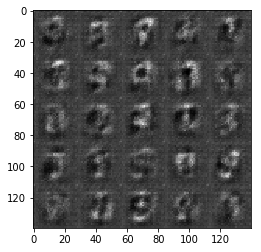

epoch: 1/2 iteration: 120 ...  d_loss: 1.0739 g_loss: 0.8280
epoch: 1/2 iteration: 140 ...  d_loss: 1.1101 g_loss: 0.7531
epoch: 1/2 iteration: 160 ...  d_loss: 1.5130 g_loss: 0.4041
epoch: 1/2 iteration: 180 ...  d_loss: 1.1421 g_loss: 0.6529
epoch: 1/2 iteration: 200 ...  d_loss: 0.9805 g_loss: 0.8747


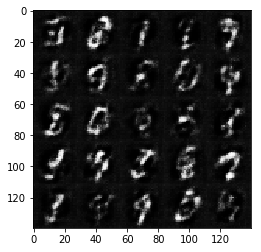

epoch: 1/2 iteration: 220 ...  d_loss: 1.1035 g_loss: 0.6998
epoch: 1/2 iteration: 240 ...  d_loss: 0.9364 g_loss: 0.9371
epoch: 1/2 iteration: 260 ...  d_loss: 1.0036 g_loss: 2.0412
epoch: 1/2 iteration: 280 ...  d_loss: 1.1131 g_loss: 2.2312
epoch: 1/2 iteration: 300 ...  d_loss: 0.8224 g_loss: 1.5296


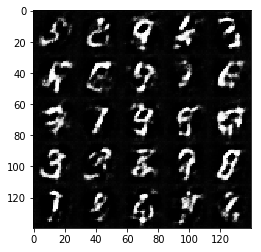

epoch: 1/2 iteration: 320 ...  d_loss: 0.9249 g_loss: 1.9758
epoch: 1/2 iteration: 340 ...  d_loss: 0.9950 g_loss: 1.6471
epoch: 1/2 iteration: 360 ...  d_loss: 0.9379 g_loss: 1.7982
epoch: 1/2 iteration: 380 ...  d_loss: 0.9100 g_loss: 1.1617
epoch: 1/2 iteration: 400 ...  d_loss: 1.0457 g_loss: 0.7653


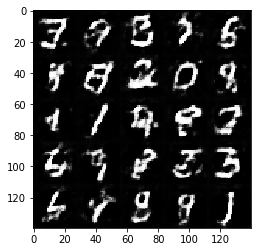

epoch: 1/2 iteration: 420 ...  d_loss: 1.0107 g_loss: 0.8367
epoch: 1/2 iteration: 440 ...  d_loss: 0.9062 g_loss: 1.0863
epoch: 1/2 iteration: 460 ...  d_loss: 1.1762 g_loss: 0.6328
epoch: 2/2 iteration: 480 ...  d_loss: 1.0935 g_loss: 1.8810
epoch: 2/2 iteration: 500 ...  d_loss: 1.3388 g_loss: 1.9667


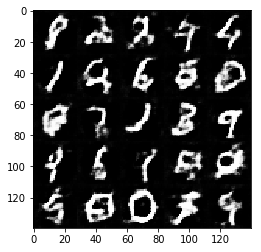

epoch: 2/2 iteration: 520 ...  d_loss: 1.3962 g_loss: 0.4828
epoch: 2/2 iteration: 540 ...  d_loss: 1.3260 g_loss: 0.5238
epoch: 2/2 iteration: 560 ...  d_loss: 0.9965 g_loss: 1.3832
epoch: 2/2 iteration: 580 ...  d_loss: 1.1092 g_loss: 1.5552
epoch: 2/2 iteration: 600 ...  d_loss: 1.7415 g_loss: 0.3327


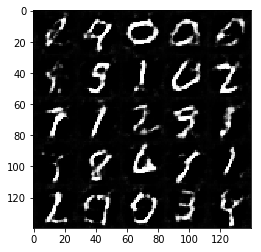

epoch: 2/2 iteration: 620 ...  d_loss: 0.9330 g_loss: 1.1874
epoch: 2/2 iteration: 640 ...  d_loss: 0.9547 g_loss: 1.0344
epoch: 2/2 iteration: 660 ...  d_loss: 1.1660 g_loss: 0.7560
epoch: 2/2 iteration: 680 ...  d_loss: 0.9770 g_loss: 1.1277
epoch: 2/2 iteration: 700 ...  d_loss: 1.4514 g_loss: 0.4898


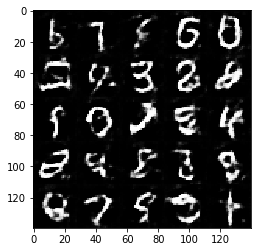

epoch: 2/2 iteration: 720 ...  d_loss: 0.8898 g_loss: 1.1635
epoch: 2/2 iteration: 740 ...  d_loss: 0.9314 g_loss: 1.1455
epoch: 2/2 iteration: 760 ...  d_loss: 1.1141 g_loss: 0.6850
epoch: 2/2 iteration: 780 ...  d_loss: 1.2059 g_loss: 0.6231
epoch: 2/2 iteration: 800 ...  d_loss: 1.0201 g_loss: 1.0782


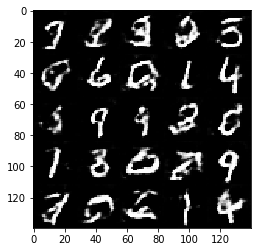

epoch: 2/2 iteration: 820 ...  d_loss: 0.9916 g_loss: 0.9190
epoch: 2/2 iteration: 840 ...  d_loss: 1.1095 g_loss: 1.8430
epoch: 2/2 iteration: 860 ...  d_loss: 0.9698 g_loss: 0.9422
epoch: 2/2 iteration: 880 ...  d_loss: 0.9815 g_loss: 1.7439
epoch: 2/2 iteration: 900 ...  d_loss: 1.6672 g_loss: 2.8446


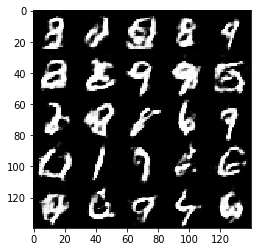

epoch: 2/2 iteration: 920 ...  d_loss: 0.9303 g_loss: 1.3822

##### Training finished. Show the generator outputs. #####


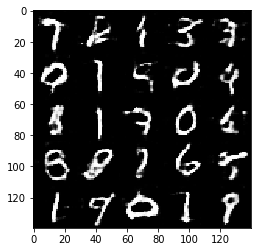

In [16]:
batch_size = 128
z_dim = 100
# start from 0.0002, then midified
learning_rate = 0.0002
# start from 0.5, then midified
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch: 1/1 iteration: 20 ...  d_loss: 1.8427 g_loss: 0.3123
epoch: 1/1 iteration: 40 ...  d_loss: 1.8402 g_loss: 0.3746
epoch: 1/1 iteration: 60 ...  d_loss: 0.7894 g_loss: 2.3506
epoch: 1/1 iteration: 80 ...  d_loss: 1.1226 g_loss: 2.0909
epoch: 1/1 iteration: 100 ...  d_loss: 1.0732 g_loss: 2.5240


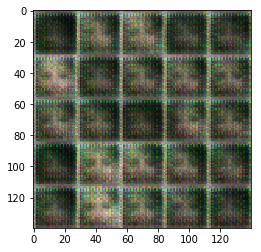

epoch: 1/1 iteration: 120 ...  d_loss: 0.8978 g_loss: 1.5269
epoch: 1/1 iteration: 140 ...  d_loss: 1.4381 g_loss: 1.1996
epoch: 1/1 iteration: 160 ...  d_loss: 1.3321 g_loss: 1.6685
epoch: 1/1 iteration: 180 ...  d_loss: 1.3447 g_loss: 1.6762
epoch: 1/1 iteration: 200 ...  d_loss: 1.4850 g_loss: 1.6332


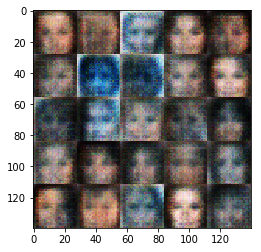

epoch: 1/1 iteration: 220 ...  d_loss: 1.2376 g_loss: 1.2253
epoch: 1/1 iteration: 240 ...  d_loss: 1.2778 g_loss: 1.7610
epoch: 1/1 iteration: 260 ...  d_loss: 1.2399 g_loss: 1.4071
epoch: 1/1 iteration: 280 ...  d_loss: 1.2853 g_loss: 1.6775
epoch: 1/1 iteration: 300 ...  d_loss: 1.1322 g_loss: 1.0064


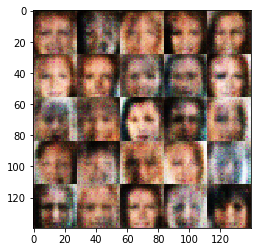

epoch: 1/1 iteration: 320 ...  d_loss: 1.2263 g_loss: 0.7085
epoch: 1/1 iteration: 340 ...  d_loss: 1.4888 g_loss: 0.4717
epoch: 1/1 iteration: 360 ...  d_loss: 1.3225 g_loss: 0.8233
epoch: 1/1 iteration: 380 ...  d_loss: 1.1252 g_loss: 1.4184
epoch: 1/1 iteration: 400 ...  d_loss: 1.4392 g_loss: 1.3698


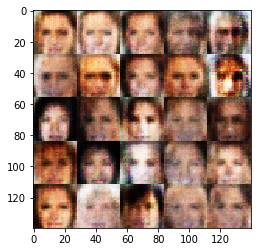

epoch: 1/1 iteration: 420 ...  d_loss: 1.2486 g_loss: 1.0931
epoch: 1/1 iteration: 440 ...  d_loss: 1.2996 g_loss: 1.2266
epoch: 1/1 iteration: 460 ...  d_loss: 1.4430 g_loss: 1.5543
epoch: 1/1 iteration: 480 ...  d_loss: 1.2833 g_loss: 0.7120
epoch: 1/1 iteration: 500 ...  d_loss: 1.6439 g_loss: 1.6490


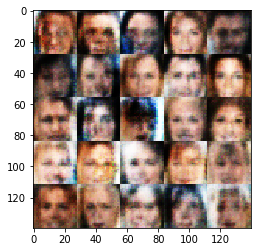

epoch: 1/1 iteration: 520 ...  d_loss: 1.1735 g_loss: 1.3225
epoch: 1/1 iteration: 540 ...  d_loss: 2.7322 g_loss: 2.2989
epoch: 1/1 iteration: 560 ...  d_loss: 1.4016 g_loss: 0.5265
epoch: 1/1 iteration: 580 ...  d_loss: 1.3066 g_loss: 0.6673
epoch: 1/1 iteration: 600 ...  d_loss: 1.5753 g_loss: 0.4051


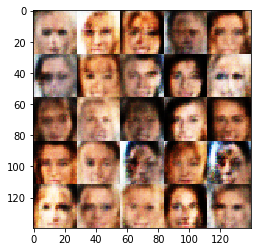

epoch: 1/1 iteration: 620 ...  d_loss: 1.3202 g_loss: 2.4303
epoch: 1/1 iteration: 640 ...  d_loss: 1.2941 g_loss: 0.8844
epoch: 1/1 iteration: 660 ...  d_loss: 1.2307 g_loss: 0.9476
epoch: 1/1 iteration: 680 ...  d_loss: 0.9066 g_loss: 1.8450
epoch: 1/1 iteration: 700 ...  d_loss: 1.3625 g_loss: 1.0125


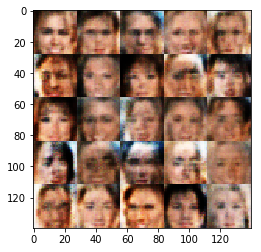

epoch: 1/1 iteration: 720 ...  d_loss: 1.3090 g_loss: 0.9923
epoch: 1/1 iteration: 740 ...  d_loss: 1.3095 g_loss: 0.7481
epoch: 1/1 iteration: 760 ...  d_loss: 1.4909 g_loss: 1.0378
epoch: 1/1 iteration: 780 ...  d_loss: 1.3809 g_loss: 0.4858
epoch: 1/1 iteration: 800 ...  d_loss: 1.5027 g_loss: 0.4465


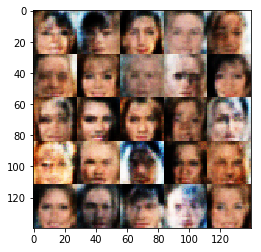

epoch: 1/1 iteration: 820 ...  d_loss: 1.5496 g_loss: 0.3852
epoch: 1/1 iteration: 840 ...  d_loss: 1.0357 g_loss: 0.8599
epoch: 1/1 iteration: 860 ...  d_loss: 1.3469 g_loss: 0.6206
epoch: 1/1 iteration: 880 ...  d_loss: 1.3116 g_loss: 0.7963
epoch: 1/1 iteration: 900 ...  d_loss: 1.5215 g_loss: 1.5238


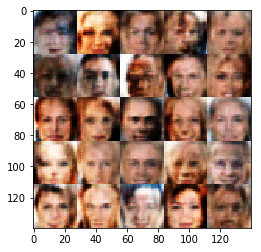

epoch: 1/1 iteration: 920 ...  d_loss: 1.3214 g_loss: 0.5569
epoch: 1/1 iteration: 940 ...  d_loss: 1.2299 g_loss: 0.7655
epoch: 1/1 iteration: 960 ...  d_loss: 0.9150 g_loss: 2.0342
epoch: 1/1 iteration: 980 ...  d_loss: 1.2451 g_loss: 0.8033
epoch: 1/1 iteration: 1000 ...  d_loss: 1.4426 g_loss: 1.5165


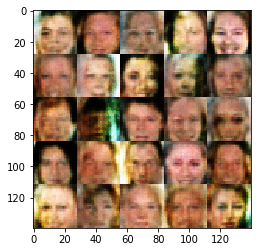

epoch: 1/1 iteration: 1020 ...  d_loss: 1.3169 g_loss: 0.7762
epoch: 1/1 iteration: 1040 ...  d_loss: 1.4480 g_loss: 0.4781
epoch: 1/1 iteration: 1060 ...  d_loss: 1.2729 g_loss: 0.8068
epoch: 1/1 iteration: 1080 ...  d_loss: 1.1840 g_loss: 1.0716
epoch: 1/1 iteration: 1100 ...  d_loss: 1.1580 g_loss: 1.8084


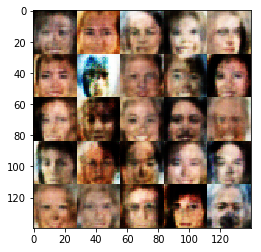

epoch: 1/1 iteration: 1120 ...  d_loss: 1.3365 g_loss: 1.2762
epoch: 1/1 iteration: 1140 ...  d_loss: 1.0963 g_loss: 1.0725
epoch: 1/1 iteration: 1160 ...  d_loss: 1.0014 g_loss: 1.2215
epoch: 1/1 iteration: 1180 ...  d_loss: 0.9523 g_loss: 1.0694
epoch: 1/1 iteration: 1200 ...  d_loss: 1.3489 g_loss: 0.5157


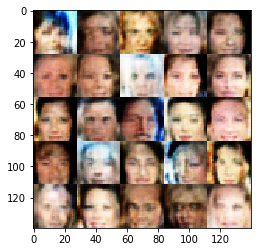

epoch: 1/1 iteration: 1220 ...  d_loss: 1.5290 g_loss: 1.9009
epoch: 1/1 iteration: 1240 ...  d_loss: 1.3996 g_loss: 1.1943
epoch: 1/1 iteration: 1260 ...  d_loss: 1.1613 g_loss: 1.3132
epoch: 1/1 iteration: 1280 ...  d_loss: 1.1141 g_loss: 1.9700
epoch: 1/1 iteration: 1300 ...  d_loss: 1.3574 g_loss: 0.7623


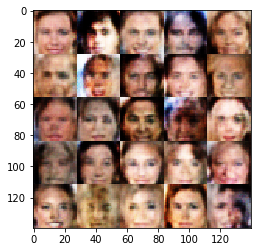

epoch: 1/1 iteration: 1320 ...  d_loss: 1.0912 g_loss: 1.2189
epoch: 1/1 iteration: 1340 ...  d_loss: 0.8490 g_loss: 1.6856
epoch: 1/1 iteration: 1360 ...  d_loss: 1.3785 g_loss: 0.9261
epoch: 1/1 iteration: 1380 ...  d_loss: 0.9810 g_loss: 1.1360
epoch: 1/1 iteration: 1400 ...  d_loss: 1.2612 g_loss: 0.7383


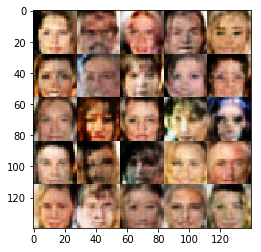

epoch: 1/1 iteration: 1420 ...  d_loss: 1.2641 g_loss: 0.5788
epoch: 1/1 iteration: 1440 ...  d_loss: 1.5282 g_loss: 1.5505
epoch: 1/1 iteration: 1460 ...  d_loss: 1.5170 g_loss: 0.4374
epoch: 1/1 iteration: 1480 ...  d_loss: 1.1550 g_loss: 0.9667
epoch: 1/1 iteration: 1500 ...  d_loss: 1.1541 g_loss: 1.0667


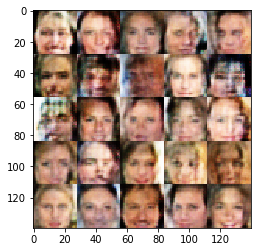

epoch: 1/1 iteration: 1520 ...  d_loss: 1.2857 g_loss: 0.5752
epoch: 1/1 iteration: 1540 ...  d_loss: 1.2159 g_loss: 0.6869
epoch: 1/1 iteration: 1560 ...  d_loss: 0.9054 g_loss: 1.0325
epoch: 1/1 iteration: 1580 ...  d_loss: 1.2630 g_loss: 1.5375

##### Training finished. Show the generator outputs. #####


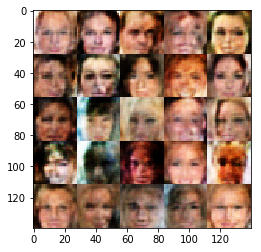

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.